# Remade Code for Waves in the Solar Wind

Dongwen He 20250408

In [1]:
from solver.constants import *
from solver import Solver

import logging
import sys
import numpy as np
logging.basicConfig(format='[%(levelname)s]%(asctime)s|%(name)s: %(message)s',
                    level=logging.INFO, stream=sys.stdout)

CONFIG = {

    # wave kinetic equation param
    'gamma_k': 0., # s^-1

    'dt': 0.1, # s
    't_max': 15, # s
    'max_variation_percentage': 0.1, # max variation per step
    'cfl': 0.4, # Courant-Friedrichs-Lewy condition

    'temperature': 1.5e6, # K
    'wave_type': 'alfven',

    'r_min': 1.0 * SOLAR_RADIUS,
    'r_max': 20 * SOLAR_RADIUS,
    'n_r': 100,

    'dtheta': 10 / 180 * np.pi,

    'k_min': 1e-8,
    'k_max': 1e-5,
    'n_k': 50,

    'dtheta_k': 10 / 180 * np.pi,

    # initial conditions
    'initial_amplitude': 1.0,
    'initial_sigma_thetak': 1e-8

}

solver = Solver(CONFIG, mode='log', to_be_iterate=True, dt_order=3)

[INFO]2025-04-11 21:03:26,345|solver.wave_kinetic_solver: No function provided for wave power initialization. Defaulting to Gaussian.
[INFO]2025-04-11 21:03:26,488|solver.wave_kinetic_solver: Time: 0.00 / 15.00
[INFO]2025-04-11 21:03:26,491|solver.wave_kinetic_solver: Time: 0.10 / 15.00
[INFO]2025-04-11 21:03:26,495|solver.wave_kinetic_solver: Time: 0.20 / 15.00
[INFO]2025-04-11 21:03:26,498|solver.wave_kinetic_solver: Time: 0.30 / 15.00
[INFO]2025-04-11 21:03:26,521|solver.wave_kinetic_solver: Time: 0.40 / 15.00
[INFO]2025-04-11 21:03:26,582|solver.wave_kinetic_solver: Time: 0.50 / 15.00
[INFO]2025-04-11 21:03:26,644|solver.wave_kinetic_solver: Time: 0.60 / 15.00
[INFO]2025-04-11 21:03:26,705|solver.wave_kinetic_solver: Time: 0.70 / 15.00
[INFO]2025-04-11 21:03:26,765|solver.wave_kinetic_solver: Time: 0.80 / 15.00
[INFO]2025-04-11 21:03:26,827|solver.wave_kinetic_solver: Time: 0.90 / 15.00
[INFO]2025-04-11 21:03:26,902|solver.wave_kinetic_solver: Time: 1.00 / 15.00
[INFO]2025-04-11 21

Text(0.5, 1.0, 'Parker Solar Wind Model')

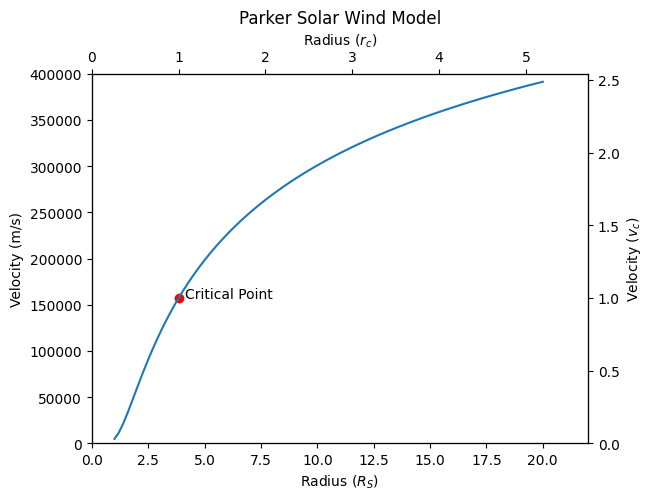

In [3]:
import matplotlib.pyplot as plt

r = solver.r.detach().cpu()[:, 0, 0, 0]
v_sw = solver.v_sw.cpu()[:, 0, 0, 0]
r_crit = solver.r_crit.cpu()
v_crit = solver.v_crit.cpu()

plt.plot(r / SOLAR_RADIUS, v_sw)
plt.scatter(r_crit / SOLAR_RADIUS, v_crit, color='red')
plt.text(r_crit / SOLAR_RADIUS + .3, v_crit, 'Critical Point')
plt.xlabel('Radius ($R_S$)')
plt.ylabel('Velocity (m/s)')
plt.xlim(0, 22)
plt.ylim(0, 4e5)

plt.twinx()
plt.ylabel('Velocity ($v_c$)')
plt.ylim(0, 4e5 / v_crit)

plt.twiny()
plt.xlabel('Radius ($r_c$)')
plt.xlim(0, 22 / r_crit * SOLAR_RADIUS)

plt.title('Parker Solar Wind Model')

[INFO]2025-04-11 04:59:36,122|solver.wave_kinetic_solver: No function provided for wave power initialization. Defaulting to Gaussian.


Text(0.5, 1.0, 'Solar Wind Density')

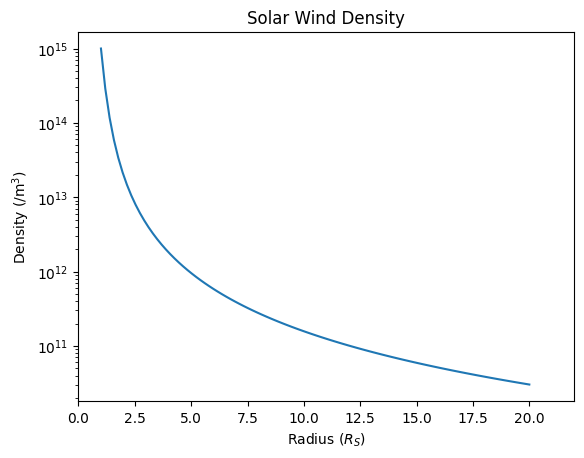

In [3]:
import matplotlib.pyplot as plt

solver = Solver(CONFIG)
r = solver.r.detach().cpu()[:, 0, 0, 0]
n_sw = solver.n_sw.detach().cpu()[:, 0, 0, 0]
r_crit = solver.r_crit.cpu()
v_crit = solver.v_crit.cpu()

plt.plot(r / SOLAR_RADIUS, n_sw)
plt.xlabel('Radius ($R_S$)')
plt.ylabel(r'Density (/$\mathrm{m}^3$)')
plt.xlim(0, 22)
plt.semilogy()

plt.title('Solar Wind Density')

C:\Users\PC\AppData\Local\Temp\ipykernel_4664\2364397079.py:10: RuntimeWarning: overflow encountered in exp
  wave_power_all = np.exp(wave_power_all)
C:\Users\PC\AppData\Local\Temp\ipykernel_4664\2364397079.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(0, 6, 1), color='white')


Text(0.5, 1.0, 'Wave Power ($dt=0.10 \\,s, t=15.1$ s)')

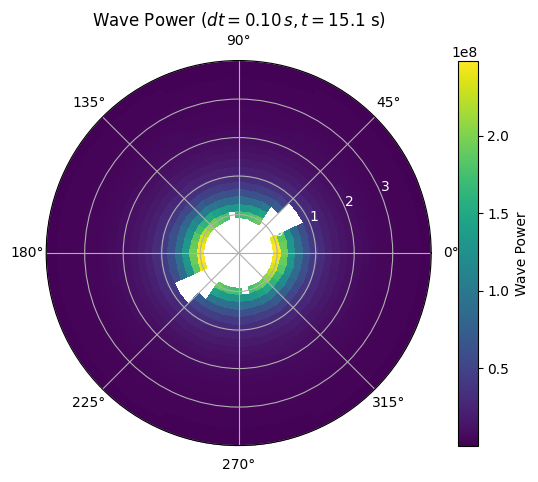

In [2]:
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='polar')
# plt.subplot(projection='polar')
wave_power_all = solver.wave_power.cpu().numpy()
if solver.mode == 'log':
    wave_power_all = np.exp(wave_power_all)
wave_power_rspace = np.nansum(wave_power_all * solver.dk ** 2 
                              * solver.dtheta_k,
                              axis=(2, 3))
# wave_power_rspace = np.mean(wave_power_all, axis=(2, 3))
r = solver.r.cpu()[:, :, 0, 0] / SOLAR_RADIUS
theta = solver.theta.cpu()[:, :, 0, 0]
pcm = ax.pcolormesh(theta, r, wave_power_rspace, shading='nearest', 
            #    norm=LogNorm(vmax=1e9)
               )
# print(np.any(np.isinf(wave_power_rspace)))
ax.set_ylim(0, 5)
ax.set_yticklabels(np.arange(0, 6, 1), color='white')
plt.colorbar(mappable=pcm, ax=ax, label='Wave Power')
ax.set_title(f'Wave Power ($dt=%.2f \,s, t={solver.t:.1f}$ s)' % CONFIG['dt'])

Text(0.5, 1.0, 'Wave Power Spectrum ($t=100.10$ s)')

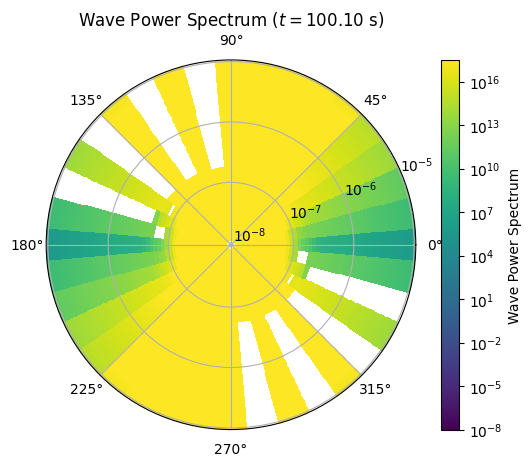

In [6]:
import numpy as np
from matplotlib.colors import LogNorm

plt.subplot(projection='polar')

wave_power_all = solver.wave_power.cpu().numpy()
if solver.mode == 'log':
    wave_power_all = np.exp(wave_power_all)

wave_power_kspace = np.mean(wave_power_all, axis=(1))[49]  # r = 10 Rs
k = solver.k.cpu()[0, 0, :, :]
theta_k = solver.theta_k.cpu()[0, 0, :, :]
plt.pcolormesh(theta_k, k, wave_power_kspace, shading='nearest', 
               norm=LogNorm(vmin=1e-8, vmax=10**17.5)
               )
plt.semilogy()
plt.colorbar(label='Wave Power Spectrum')
plt.title(f'Wave Power Spectrum ($t={solver.t:.2f}$ s)')
